In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

import EnergyPricesLibrary as Ep
import math

from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [15]:
def get_callbacks(monitor='loss'):
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                      patience=5,
                                                      mode='min')

    callbacks = [callback_reduce_lr,early_stopping]
    
    return callbacks

def get_model(n_steps_in,n_steps_out,len_input_features,len_output_features):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(5, activation='tanh', input_shape=(n_steps_in,len_input_features)))
    model.add(tf.keras.layers.RepeatVector(n_steps_out))
    model.add(tf.keras.layers.LSTM(5, activation='tanh', return_sequences=True))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len_output_features)))
    
    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=tf.losses.MeanSquaredError(),
                  metrics=[tf.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    return model

def make_predictions(model,scaler_X,scaler_Y,trainX,trainY,testX,testY,n_steps_out,len_output_features):
    
    # make predictions
    trainPredict = model.predict(trainX)
    trainPredict = trainPredict.reshape(trainPredict.shape[0]*n_steps_out,len_output_features)
    testPredict  = model.predict(testX)
    testPredict  = testPredict.reshape(testPredict.shape[0]*n_steps_out,len_output_features)
    
    # invert predictions
    trainPredict = scaler_X.inverse_transform(trainPredict)
    trainY = scaler_Y.inverse_transform(trainY.reshape(trainY.shape[0]*n_steps_out,1))
    testPredict = scaler_X.inverse_transform(testPredict)
    testY = scaler_Y.inverse_transform(testY.reshape(testY.shape[0]*n_steps_out,1))
    
    return trainPredict,trainY,testPredict,testY

def get_metrics(trainY,trainPredict,testY,testPredict):
    
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    trainMAPE  = Ep.MAPE(trainPredict,trainY)
    print('Train Score: %.2f RMSE' % trainScore)
    print('Train Score: %.2f MAPE' % trainMAPE)
    
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    testMAPE  = Ep.MAPE(testPredict,testY)
    print('Test Score: %.2f RMSE' % testScore)
    print('Test Score: %.2f MAPE' % testMAPE)
    
    return trainScore,trainMAPE,testScore,testMAPE

# DATASET

## Load Dataset

In [3]:
data_horaria_path = os.path.join('..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Horaria.xlsx')
data_horaria = pd.read_excel(data_horaria_path)
data_horaria = data_horaria.set_index('Fecha')

In [4]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Precio_Bolsa.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

In [5]:
full_df = pd.concat([data_horaria,precio_bolsa],axis=1)
full_df.shape,data_horaria.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
nombre_series = full_df.columns

In [7]:
full_df['just_date'] = full_df.index.date
full_df['day_of_week'] = full_df.index.day_name()
full_df['month'] = full_df.index.strftime('%b')
full_df['Year'] = full_df.index.year

## Día por separado

(7259, 24, 1) (7259, 24, 1) (105, 24, 1) (105, 24, 1)
Epoch 1/200
227/227 [==============================] - 2s 8ms/step - loss: 7.0832e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 1246.4177 - symmetric_mean_absolute_percentage_error: 825.4471
Epoch 2/200
227/227 [==============================] - 2s 8ms/step - loss: 2.3752e-04 - mean_absolute_error: 0.0071 - mean_absolute_percentage_error: 1387.5243 - symmetric_mean_absolute_percentage_error: 592.1144
Epoch 3/200
221/227 [============================>.] - ETA: 0s - loss: 2.0969e-04 - mean_absolute_error: 0.0071 - mean_absolute_percentage_error: 1363.4417 - symmetric_mean_absolute_percentage_error: 595.9673
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
227/227 [==============================] - 2s 8ms/step - loss: 2.0855e-04 - mean_absolute_error: 0.0071 - mean_absolute_percentage_error: 1329.1276 - symmetric_mean_absolute_percentage_error: 594.4845
Epoch 4/200
225/227 [========

227/227 [==============================] - 2s 8ms/step - loss: 1.7592e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1451.4791 - symmetric_mean_absolute_percentage_error: 564.4926
Epoch 37/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7485e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1481.8744 - symmetric_mean_absolute_percentage_error: 561.6782
Epoch 38/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7431e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1658.5576 - symmetric_mean_absolute_percentage_error: 561.5775
Epoch 39/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7450e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1467.3480 - symmetric_mean_absolute_percentage_error: 560.7717
Epoch 40/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7423e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1421.4

227/227 [==============================] - 2s 8ms/step - loss: 1.6498e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1477.1243 - symmetric_mean_absolute_percentage_error: 550.6030
Epoch 73/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6532e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1489.4524 - symmetric_mean_absolute_percentage_error: 552.5770
Epoch 74/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6404e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1451.8625 - symmetric_mean_absolute_percentage_error: 551.3216
Epoch 75/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6405e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1366.3885 - symmetric_mean_absolute_percentage_error: 548.9073
Epoch 76/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6423e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1473.6

227/227 [==============================] - 2s 8ms/step - loss: 1.5797e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1434.8109 - symmetric_mean_absolute_percentage_error: 547.2015
Epoch 110/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5806e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1476.1714 - symmetric_mean_absolute_percentage_error: 543.9465
Epoch 111/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5779e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1395.0587 - symmetric_mean_absolute_percentage_error: 543.3307
Epoch 112/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5792e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1450.8473 - symmetric_mean_absolute_percentage_error: 544.4308
Epoch 113/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5710e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 14

227/227 [==============================] - 2s 8ms/step - loss: 1.8140e-04 - mean_absolute_error: 0.0067 - mean_absolute_percentage_error: 1310.8024 - symmetric_mean_absolute_percentage_error: 592.1546
Epoch 25/200
227/227 [==============================] - 2s 8ms/step - loss: 1.8007e-04 - mean_absolute_error: 0.0067 - mean_absolute_percentage_error: 1267.8605 - symmetric_mean_absolute_percentage_error: 593.6015
Epoch 26/200
227/227 [==============================] - 2s 8ms/step - loss: 1.8003e-04 - mean_absolute_error: 0.0067 - mean_absolute_percentage_error: 1271.2661 - symmetric_mean_absolute_percentage_error: 592.2615
Epoch 27/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7872e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1354.6112 - symmetric_mean_absolute_percentage_error: 588.2468
Epoch 28/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7753e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1370.0

227/227 [==============================] - 2s 8ms/step - loss: 1.4998e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1383.1813 - symmetric_mean_absolute_percentage_error: 548.2832: 0s - loss: 1.5451e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1541.7977 - symmetric_mean_absolute_percentage_error: 54
Epoch 62/200
227/227 [==============================] - 2s 7ms/step - loss: 1.4947e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1420.7982 - symmetric_mean_absolute_percentage_error: 544.3126
Epoch 63/200
227/227 [==============================] - 2s 7ms/step - loss: 1.4837e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1503.5366 - symmetric_mean_absolute_percentage_error: 545.9284
Epoch 64/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4782e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1441.4851 - symmetric_mean_absolute_percentage_error: 543.2101
Epoch 65/200


227/227 [==============================] - 2s 8ms/step - loss: 1.3682e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1383.4506 - symmetric_mean_absolute_percentage_error: 503.0606: 0s - loss: 1.4736e-04 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 1560.0143 - symmetric_mean_absolute_percentage
Epoch 99/200
227/227 [==============================] - 2s 8ms/step - loss: 1.3642e-04 - mean_absolute_error: 0.0058 - mean_absolute_percentage_error: 1417.2670 - symmetric_mean_absolute_percentage_error: 497.2436
Epoch 100/200
227/227 [==============================] - 2s 8ms/step - loss: 1.3661e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1418.1855 - symmetric_mean_absolute_percentage_error: 502.3641
Epoch 101/200
227/227 [==============================] - 2s 8ms/step - loss: 1.3582e-04 - mean_absolute_error: 0.0058 - mean_absolute_percentage_error: 1390.7260 - symmetric_mean_absolute_percentage_error: 494.6071
Epoch 102/200
227/227

223/227 [============================>.] - ETA: 0s - loss: 2.0058e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1521.5460 - symmetric_mean_absolute_percentage_error: 567.1090
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001.
227/227 [==============================] - 2s 8ms/step - loss: 2.0414e-04 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 1496.2924 - symmetric_mean_absolute_percentage_error: 566.2732
Epoch 5/200
227/227 [==============================] - 2s 7ms/step - loss: 2.0316e-04 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 1589.7953 - symmetric_mean_absolute_percentage_error: 573.3798
Epoch 6/200
227/227 [==============================] - 2s 7ms/step - loss: 2.0207e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1541.9055 - symmetric_mean_absolute_percentage_error: 569.9846
Epoch 7/200
227/227 [==============================] - 2s 8ms/step - loss: 2.0142e-04 - mean_absolute_error: 0.

227/227 [==============================] - 2s 8ms/step - loss: 1.7527e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1526.7812 - symmetric_mean_absolute_percentage_error: 563.8498
Epoch 42/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7624e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1379.6332 - symmetric_mean_absolute_percentage_error: 567.5195
Epoch 43/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7504e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1504.7744 - symmetric_mean_absolute_percentage_error: 567.9786
Epoch 44/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7513e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1427.2406 - symmetric_mean_absolute_percentage_error: 568.1081: 0s - loss: 2.0096e-04 - mean_absolute_error: 0.0068 - mean_absolute_percentage_error: 1907.9884 - symmetric_mean_absol
Epoch 45/200
227/227 [===============

227/227 [==============================] - 2s 8ms/step - loss: 1.6324e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1415.6335 - symmetric_mean_absolute_percentage_error: 561.8519
Epoch 78/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6306e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1577.4540 - symmetric_mean_absolute_percentage_error: 561.9086
Epoch 79/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6259e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1477.2434 - symmetric_mean_absolute_percentage_error: 560.0718
Epoch 80/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6130e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1368.6202 - symmetric_mean_absolute_percentage_error: 558.4487A: 1s - loss: 1.5926e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1163.2136 - symme
Epoch 81/200
227/227 [=============================

227/227 [==============================] - 2s 8ms/step - loss: 1.4833e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1449.0737 - symmetric_mean_absolute_percentage_error: 536.9698
Epoch 115/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4779e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1499.6420 - symmetric_mean_absolute_percentage_error: 536.9997
Epoch 116/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4718e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1437.5063 - symmetric_mean_absolute_percentage_error: 536.6349
Epoch 117/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4761e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1423.3682 - symmetric_mean_absolute_percentage_error: 538.1201
Epoch 118/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4696e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 14

227/227 [==============================] - 2s 8ms/step - loss: 1.4128e-04 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 1432.9952 - symmetric_mean_absolute_percentage_error: 512.8983
Train Score: 33.11 RMSE
Train Score: 0.16 MAPE
Test Score: 53.17 RMSE
Test Score: 0.13 MAPE
(7259, 24, 1) (7259, 24, 1) (105, 24, 1) (105, 24, 1)
Epoch 1/200
227/227 [==============================] - 2s 8ms/step - loss: 6.0364e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 3285.4233 - symmetric_mean_absolute_percentage_error: 869.6643
Epoch 2/200
227/227 [==============================] - 2s 8ms/step - loss: 2.1258e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1501.4993 - symmetric_mean_absolute_percentage_error: 580.2596
Epoch 3/200
225/227 [============================>.] - ETA: 0s - loss: 2.0070e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1166.5845 - symmetric_mean_absolute_percentage_error: 576.4265
Epoch 00003: Reduc

227/227 [==============================] - 2s 8ms/step - loss: 1.7183e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1477.0968 - symmetric_mean_absolute_percentage_error: 553.9772
Epoch 36/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7203e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1322.5480 - symmetric_mean_absolute_percentage_error: 557.7361
Epoch 37/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7161e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1362.8761 - symmetric_mean_absolute_percentage_error: 554.6982
Epoch 38/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7087e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1241.8633 - symmetric_mean_absolute_percentage_error: 555.7177
Epoch 39/200
227/227 [==============================] - 2s 8ms/step - loss: 1.7095e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1355.8

227/227 [==============================] - 2s 8ms/step - loss: 1.6231e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1470.9689 - symmetric_mean_absolute_percentage_error: 543.7812
Epoch 74/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6205e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1454.3369 - symmetric_mean_absolute_percentage_error: 544.8170
Epoch 75/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6206e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1435.3540 - symmetric_mean_absolute_percentage_error: 544.8914
Epoch 76/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6229e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1583.7791 - symmetric_mean_absolute_percentage_error: 541.2830
Epoch 77/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6129e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1391.2

227/227 [==============================] - 2s 8ms/step - loss: 1.5572e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1402.9844 - symmetric_mean_absolute_percentage_error: 535.2694
Epoch 111/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5535e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1476.5450 - symmetric_mean_absolute_percentage_error: 534.8244
Epoch 112/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5515e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1481.1862 - symmetric_mean_absolute_percentage_error: 537.3639
Epoch 113/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5513e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1492.8644 - symmetric_mean_absolute_percentage_error: 538.2054
Epoch 114/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5484e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 16

227/227 [==============================] - 2s 8ms/step - loss: 1.9901e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1562.0139 - symmetric_mean_absolute_percentage_error: 571.5104
Epoch 11/200
227/227 [==============================] - 2s 8ms/step - loss: 1.9716e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1522.5276 - symmetric_mean_absolute_percentage_error: 572.8090
Epoch 12/200
227/227 [==============================] - 2s 7ms/step - loss: 1.9504e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1490.4955 - symmetric_mean_absolute_percentage_error: 570.1523
Epoch 13/200
227/227 [==============================] - 2s 7ms/step - loss: 1.9336e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1553.7538 - symmetric_mean_absolute_percentage_error: 572.1060
Epoch 14/200
227/227 [==============================] - 2s 8ms/step - loss: 1.9157e-04 - mean_absolute_error: 0.0068 - mean_absolute_percentage_error: 1524.3

227/227 [==============================] - 2s 8ms/step - loss: 1.6897e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1421.3470 - symmetric_mean_absolute_percentage_error: 550.0778
Epoch 49/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6873e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1331.2654 - symmetric_mean_absolute_percentage_error: 553.6448
Epoch 50/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6810e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1325.9894 - symmetric_mean_absolute_percentage_error: 549.5558
Epoch 51/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6789e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1312.7385 - symmetric_mean_absolute_percentage_error: 551.6615
Epoch 52/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6732e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1482.8

227/227 [==============================] - 2s 8ms/step - loss: 1.5841e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1405.0153 - symmetric_mean_absolute_percentage_error: 534.8342
Epoch 86/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5774e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1385.8652 - symmetric_mean_absolute_percentage_error: 533.8252
Epoch 87/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5713e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1433.9810 - symmetric_mean_absolute_percentage_error: 538.1854
Epoch 88/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5711e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1371.2107 - symmetric_mean_absolute_percentage_error: 536.0295
Epoch 89/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5800e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1444.9

227/227 [==============================] - 2s 8ms/step - loss: 1.5038e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1384.3419 - symmetric_mean_absolute_percentage_error: 516.4468
Epoch 124/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5038e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1410.7714 - symmetric_mean_absolute_percentage_error: 521.2516
Epoch 125/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4955e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1461.2419 - symmetric_mean_absolute_percentage_error: 516.4337
Epoch 126/200
227/227 [==============================] - 2s 8ms/step - loss: 1.5028e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1396.9653 - symmetric_mean_absolute_percentage_error: 520.1892
Epoch 127/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4944e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 14

227/227 [==============================] - 2s 8ms/step - loss: 1.4473e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1319.3809 - symmetric_mean_absolute_percentage_error: 508.7761
Epoch 161/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4528e-04 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 1392.0928 - symmetric_mean_absolute_percentage_error: 505.3311
Epoch 162/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4486e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1325.9773 - symmetric_mean_absolute_percentage_error: 506.2249
Epoch 163/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4498e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1349.6616 - symmetric_mean_absolute_percentage_error: 506.3553
Epoch 164/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4511e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 13

227/227 [==============================] - 2s 8ms/step - loss: 1.8394e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1391.4797 - symmetric_mean_absolute_percentage_error: 564.2607
Epoch 30/200
227/227 [==============================] - 2s 9ms/step - loss: 1.8329e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1440.7324 - symmetric_mean_absolute_percentage_error: 561.96162s - loss: 1.1431e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error
Epoch 31/200
227/227 [==============================] - 2s 8ms/step - loss: 1.8262e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1486.7812 - symmetric_mean_absolute_percentage_error: 563.7637
Epoch 32/200
227/227 [==============================] - 2s 8ms/step - loss: 1.8251e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1570.2269 - symmetric_mean_absolute_percentage_error: 566.6235
Epoch 33/200
227/227 [==============================] - 2s 8ms/step - los

227/227 [==============================] - 5s 22ms/step - loss: 1.7267e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1566.9796 - symmetric_mean_absolute_percentage_error: 561.7195
Epoch 63/200
227/227 [==============================] - 4s 19ms/step - loss: 1.7235e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1531.1732 - symmetric_mean_absolute_percentage_error: 556.4256 0s - loss: 1.7339e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1658.2551 - symmetric_mean_absol
Epoch 64/200
227/227 [==============================] - 5s 23ms/step - loss: 1.7238e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1485.0120 - symmetric_mean_absolute_percentage_error: 559.2803
Epoch 65/200
227/227 [==============================] - 5s 21ms/step - loss: 1.7288e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1529.5018 - symmetric_mean_absolute_percentage_error: 560.3074 1s - loss: 1.5225e-04 - mean_absol

227/227 [==============================] - 2s 10ms/step - loss: 1.6533e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1413.9720 - symmetric_mean_absolute_percentage_error: 547.2685
Epoch 95/200
227/227 [==============================] - 4s 16ms/step - loss: 1.6455e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1501.9272 - symmetric_mean_absolute_percentage_error: 552.7559
Epoch 96/200
227/227 [==============================] - 4s 16ms/step - loss: 1.6511e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1586.1952 - symmetric_mean_absolute_percentage_error: 551.8240
Epoch 97/200
227/227 [==============================] - 3s 11ms/step - loss: 1.6506e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1514.9382 - symmetric_mean_absolute_percentage_error: 555.3382
Epoch 98/200
227/227 [==============================] - 3s 12ms/step - loss: 1.6417e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1

227/227 [==============================] - 3s 12ms/step - loss: 1.5947e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1515.6211 - symmetric_mean_absolute_percentage_error: 545.0054
Epoch 127/200
227/227 [==============================] - 3s 13ms/step - loss: 1.5898e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1543.3824 - symmetric_mean_absolute_percentage_error: 543.5987s - loss: 1.0227e-04 - mean_absolute_error: 0.0061 - mean_absolute_perc
Epoch 128/200
227/227 [==============================] - 3s 12ms/step - loss: 1.5954e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1487.2135 - symmetric_mean_absolute_percentage_error: 547.7668s - loss: 1.7735e-04 - mean_absolute_error: 0.0066 - mean_a
Epoch 129/200
227/227 [==============================] - 3s 12ms/step - loss: 1.5863e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1481.4235 - symmetric_mean_absolute_percentage_error: 541.7474
Epoch 130/200
227/22

227/227 [==============================] - 5s 20ms/step - loss: 1.5395e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1585.7422 - symmetric_mean_absolute_percentage_error: 536.7135
Epoch 160/200
227/227 [==============================] - 4s 19ms/step - loss: 1.5371e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1547.3088 - symmetric_mean_absolute_percentage_error: 536.0694
Epoch 161/200
227/227 [==============================] - 5s 20ms/step - loss: 1.5347e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1628.4954 - symmetric_mean_absolute_percentage_error: 536.8711
Epoch 162/200
227/227 [==============================] - 4s 17ms/step - loss: 1.5340e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1593.9224 - symmetric_mean_absolute_percentage_error: 538.9772
Epoch 163/200
227/227 [==============================] - 4s 16ms/step - loss: 1.5333e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_erro

227/227 [==============================] - 2s 7ms/step - loss: 1.4787e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1505.4156 - symmetric_mean_absolute_percentage_error: 527.9113
Epoch 196/200
227/227 [==============================] - 2s 7ms/step - loss: 1.4721e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1533.1420 - symmetric_mean_absolute_percentage_error: 525.4443
Epoch 197/200
227/227 [==============================] - 2s 7ms/step - loss: 1.4739e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1532.8733 - symmetric_mean_absolute_percentage_error: 532.4665
Epoch 198/200
227/227 [==============================] - 2s 7ms/step - loss: 1.4726e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 1563.8425 - symmetric_mean_absolute_percentage_error: 526.6287
Epoch 199/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4713e-04 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 15

227/227 [==============================] - 2s 7ms/step - loss: 1.7975e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1369.3357 - symmetric_mean_absolute_percentage_error: 573.2766
Epoch 31/200
227/227 [==============================] - 1s 7ms/step - loss: 1.7796e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1349.6455 - symmetric_mean_absolute_percentage_error: 565.4736
Epoch 32/200
227/227 [==============================] - 1s 6ms/step - loss: 1.7785e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1330.2816 - symmetric_mean_absolute_percentage_error: 569.0253
Epoch 33/200
227/227 [==============================] - 1s 6ms/step - loss: 1.7797e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 1393.7854 - symmetric_mean_absolute_percentage_error: 568.6453
Epoch 34/200
227/227 [==============================] - 1s 7ms/step - loss: 1.7684e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 1343.8

227/227 [==============================] - 2s 7ms/step - loss: 1.6717e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1418.6609 - symmetric_mean_absolute_percentage_error: 556.8543
Epoch 69/200
227/227 [==============================] - 2s 7ms/step - loss: 1.6834e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1519.4788 - symmetric_mean_absolute_percentage_error: 561.1362
Epoch 70/200
227/227 [==============================] - 2s 7ms/step - loss: 1.6842e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1477.9497 - symmetric_mean_absolute_percentage_error: 561.3613: 0s - loss: 1.7761e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1905.9348 - symmetric_mean_absolute_perc
Epoch 71/200
227/227 [==============================] - 2s 7ms/step - loss: 1.6721e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1386.5872 - symmetric_mean_absolute_percentage_error: 555.1184
Epoch 72/200
227/227 [=======

227/227 [==============================] - 2s 7ms/step - loss: 1.6073e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1450.1479 - symmetric_mean_absolute_percentage_error: 549.7923
Epoch 106/200
227/227 [==============================] - 2s 7ms/step - loss: 1.6102e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1550.4991 - symmetric_mean_absolute_percentage_error: 551.0465
Epoch 107/200
227/227 [==============================] - 2s 7ms/step - loss: 1.5995e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1468.4565 - symmetric_mean_absolute_percentage_error: 547.2627
Epoch 108/200
227/227 [==============================] - 2s 7ms/step - loss: 1.5985e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1452.6475 - symmetric_mean_absolute_percentage_error: 549.3087
Epoch 109/200
227/227 [==============================] - 2s 7ms/step - loss: 1.6023e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 13

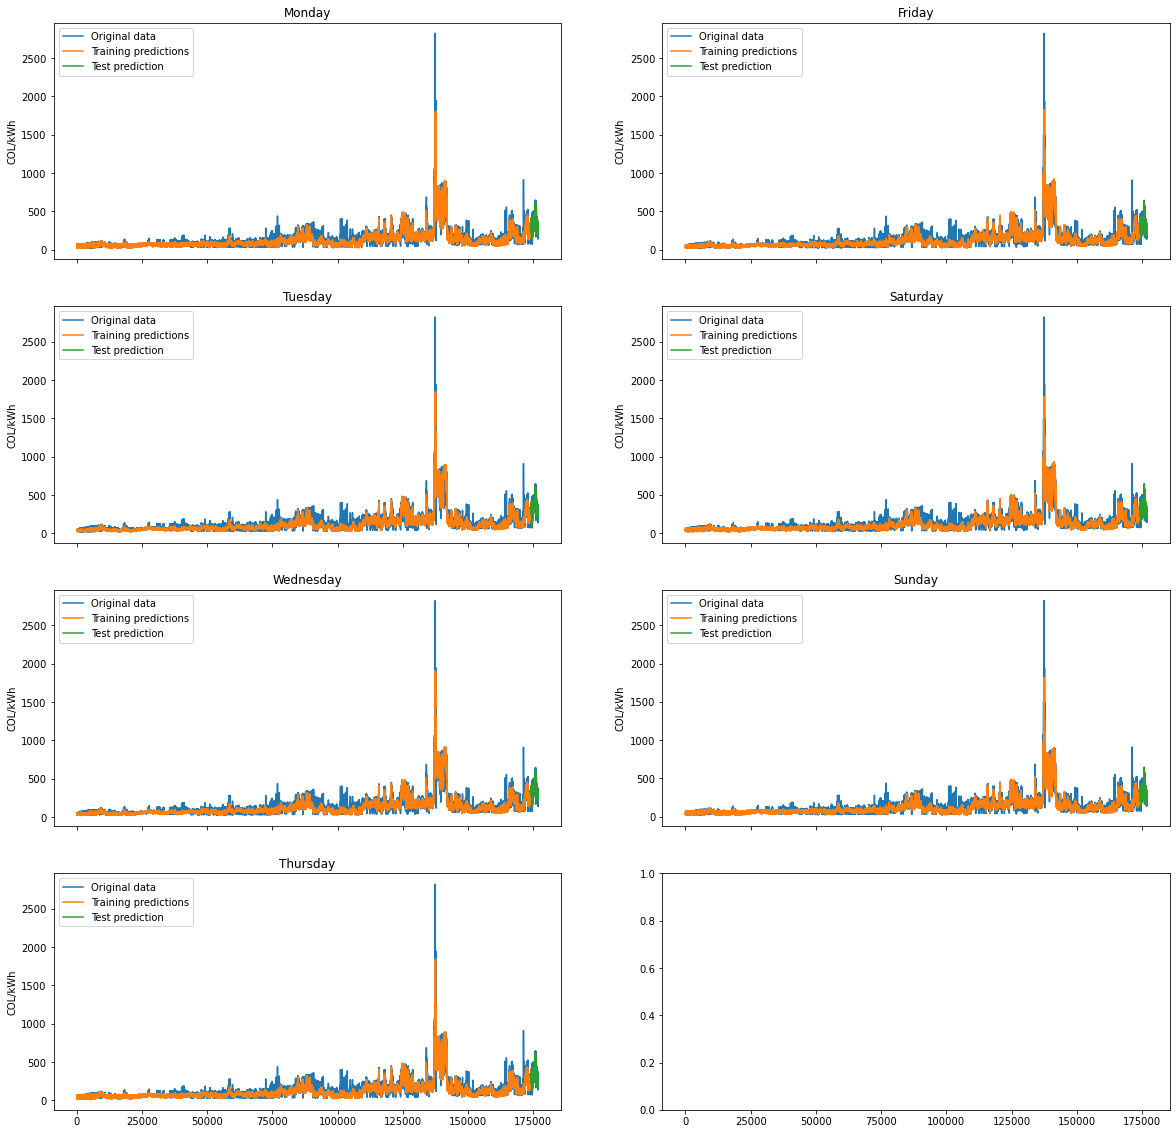

In [22]:
Days = np.array(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig, axs = plt.subplots(4, 2, sharex='all')
fig.set_size_inches(20,20)
k1 = 0
k2 = 0

IndLastMonth = '2019-12-18'
n_steps_in = 24
n_steps_out=24
overlap = 24
input_features = ['$kWh']
output_features = ['$kWh']

for j,d in enumerate(Days):
    
    trainX, trainY, testX, testY, scaler_x,scaler_y, df2, dataset = Ep.SplitTimeseriesMultipleTimesBackAhead(full_df,
                                                                                              day = d, 
                                                                                              ValData = 'index', 
                                                                                              TimeAhead = IndLastMonth,
                                                                                              n_steps_in =n_steps_in,
                                                                                              n_steps_out=n_steps_out, 
                                                                                              overlap =overlap,
                                                                                              input_features=input_features,
                                                                                              output_features=output_features)
    print(trainX.shape,trainY.shape,testX.shape,testY.shape)
    
    callbacks = get_callbacks(monitor='loss')

    # create and fit the LSTM network
    len_input_features = len(input_features)
    len_output_features = len(output_features)

    model = get_model(n_steps_in,n_steps_out,len_input_features,len_output_features)
    model.fit(trainX, trainY, epochs=200,callbacks=callbacks,verbose=1)
    
    trainPredict,trainY,testPredict,testY = make_predictions(model,scaler_x,scaler_y,trainX,trainY,testX,
                                                             testY,n_steps_out,len_output_features)
    
    trainScore,trainMAPE,testScore,testMAPE = get_metrics(trainY,trainPredict,testY,testPredict)
    
    datasetO = dataset
    Nt = trainPredict.shape[0] + testPredict.shape[0]
    trainPredictPlot = np.zeros((Nt,1))
    trainPredictPlot[:,:] = np.nan
    trainPredictPlot[:len(trainPredict), :] = np.concatenate((datasetO[0].reshape(1,1),trainPredict[:-1]))
    # shift test predictions for plotting
    testPredictPlot = np.zeros((Nt,1))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict):Nt, :] = testPredict
    
    k1 = j
    if j > 3:
        k1 = j-4
        k2 = 1
    
    axs[k1,k2].plot(dataset,label='Original data')
    axs[k1,k2].plot(trainPredictPlot,label='Training predictions')
    axs[k1,k2].plot(testPredictPlot,label='Test prediction')
    
    axs[k1,k2].set_title(d)
    axs[k1,k2].legend()
    axs[k1,k2].set_ylabel('COL/kWh')

## Todos los días

In [18]:
d = 'All'
IndLastMonth = '2019-12-18'
n_steps_in = 24
n_steps_out=24
overlap = 24
input_features = ['$kWh']
output_features = ['$kWh']

trainX, trainY, testX, testY, scaler_x,scaler_y, df2, dataset = Ep.SplitTimeseriesMultipleTimesBackAhead(full_df,
                                                                                              day = d, 
                                                                                              ValData = 'index', 
                                                                                              TimeAhead = IndLastMonth, 
                                                                                              n_steps_out=n_steps_out, 
                                                                                              n_steps_in =n_steps_in, 
                                                                                              overlap =overlap,
                                                                                              input_features=input_features,
                                                                                              output_features=output_features)
trainX.shape,trainY.shape,testX.shape,testY.shape

((7259, 24, 1), (7259, 24, 1), (105, 24, 1), (105, 24, 1))

In [12]:
callbacks = get_callbacks(monitor='loss')

# create and fit the LSTM network
len_input_features = len(input_features)
len_output_features = len(output_features)

model = get_model(n_steps_in,n_steps_out,len_input_features,len_output_features)
model.fit(trainX, trainY, epochs=200,callbacks=callbacks,verbose=1)

Epoch 1/200
227/227 [==============================] - 2s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0165 - mean_absolute_percentage_error: 6782.1421 - symmetric_mean_absolute_percentage_error: 1116.5217
Epoch 2/200
227/227 [==============================] - 2s 8ms/step - loss: 2.1031e-04 - mean_absolute_error: 0.0068 - mean_absolute_percentage_error: 1248.1857 - symmetric_mean_absolute_percentage_error: 558.1750
Epoch 3/200
224/227 [============================>.] - ETA: 0s - loss: 1.9805e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1400.0992 - symmetric_mean_absolute_percentage_error: 570.0295
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
227/227 [==============================] - 2s 8ms/step - loss: 1.9700e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1382.9564 - symmetric_mean_absolute_percentage_error: 570.1078
Epoch 4/200
226/227 [============================>.] - ETA: 0s - loss: 1.8402e-04 - me

227/227 [==============================] - 2s 7ms/step - loss: 1.6422e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1323.0200 - symmetric_mean_absolute_percentage_error: 544.0199
Epoch 37/200
227/227 [==============================] - 2s 7ms/step - loss: 1.6370e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1471.3717 - symmetric_mean_absolute_percentage_error: 546.9280
Epoch 38/200
227/227 [==============================] - 2s 7ms/step - loss: 1.6324e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1358.8782 - symmetric_mean_absolute_percentage_error: 540.2784
Epoch 39/200
227/227 [==============================] - 2s 8ms/step - loss: 1.6250e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1312.9938 - symmetric_mean_absolute_percentage_error: 543.1630
Epoch 40/200
227/227 [==============================] - 2s 7ms/step - loss: 1.6200e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 1405.4

227/227 [==============================] - 2s 8ms/step - loss: 1.4434e-04 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 1322.2417 - symmetric_mean_absolute_percentage_error: 507.8573
Epoch 75/200
227/227 [==============================] - 2s 8ms/step - loss: 1.4378e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1383.9178 - symmetric_mean_absolute_percentage_error: 503.9174
Epoch 76/200
227/227 [==============================] - 2s 7ms/step - loss: 1.4357e-04 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 1273.3779 - symmetric_mean_absolute_percentage_error: 506.1128
Epoch 77/200
227/227 [==============================] - 2s 7ms/step - loss: 1.4332e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1431.4260 - symmetric_mean_absolute_percentage_error: 501.9365
Epoch 78/200
227/227 [==============================] - 2s 7ms/step - loss: 1.4326e-04 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 1404.3

227/227 [==============================] - 2s 7ms/step - loss: 1.3720e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1346.8423 - symmetric_mean_absolute_percentage_error: 488.5706
Epoch 113/200
227/227 [==============================] - ETA: 0s - loss: 1.3768e-04 - mean_absolute_error: 0.0058 - mean_absolute_percentage_error: 1444.0558 - symmetric_mean_absolute_percentage_error: 489.97 - 2s 8ms/step - loss: 1.3737e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1426.2550 - symmetric_mean_absolute_percentage_error: 489.4287
Epoch 114/200
227/227 [==============================] - 2s 8ms/step - loss: 1.3745e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1458.1925 - symmetric_mean_absolute_percentage_error: 488.6207
Epoch 115/200
227/227 [==============================] - 2s 7ms/step - loss: 1.3678e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1372.5753 - symmetric_mean_absolute_percentage_error: 487.7736


In [16]:
trainPredict,trainY,testPredict,testY = make_predictions(model,scaler_x,scaler_y,trainX,trainY,testX,
                                                         testY,n_steps_out,len_output_features)

trainScore,trainMAPE,testScore,testMAPE = get_metrics(trainY,trainPredict,testY,testPredict)

Train Score: 33.00 RMSE
Train Score: 0.17 MAPE
Test Score: 52.98 RMSE
Test Score: 0.13 MAPE


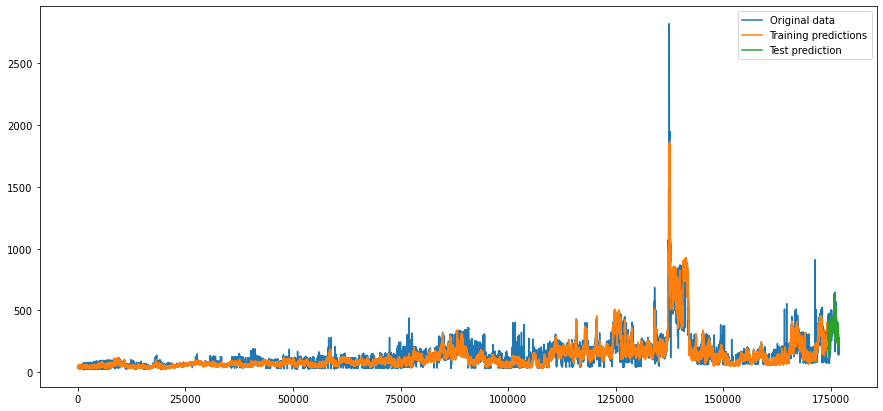

In [17]:
Nt = trainPredict.shape[0] + testPredict.shape[0]
trainPredictPlot = np.zeros((Nt,1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[:len(trainPredict), :] = np.concatenate((dataset[0].reshape(1,1),trainPredict[:-1]))
# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(dataset,label='Original data')
plt.plot(trainPredictPlot,label='Training predictions')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()

### Espacio por si quiero probar un nuevo generador

In [ ]:
date_begin = np.datetime64('2000-01-01T00:00:00')
date_end = np.datetime64('2000-06-30T00:00:00')
Time = np.arange(date_begin,date_end,dtype='datetime64[h]')

In [ ]:
Series = np.arange(24*181).reshape(-1,1)+1
Series = np.repeat(Series,5,axis=1)
Serie_pred = np.arange(24*181).reshape(-1,1)+1+(24*181)

In [ ]:
Times_df  = pd.DataFrame(Time,columns=['Fecha'])
Series_df = pd.DataFrame(Series,columns=['Serie {}'.format(i) for i in range(Series.shape[1])])
Serie_pred_df = pd.DataFrame(Serie_pred,columns=['$kWh'])

In [ ]:
data = pd.concat([Times_df,Series_df,Serie_pred_df],axis=1)

In [ ]:
data['just_date'] = data['Fecha'].dt.date
data['day_of_week'] = data['Fecha'].dt.day_name()
data['month'] = data['Fecha'].dt.strftime('%b')
data['Year'] = data['Fecha'].dt.year

In [ ]:
input_features = ['Serie 0', 'Serie 1', 'Serie 2', 'Serie 3', 'Serie 4', '$kWh']

In [ ]:
d = 'Friday'
IndLastMonth = 100
n_steps_in = 24
n_steps_out=24
overlap = 24

trainX, trainY, testX, testY, scaler, df2, dataset = Ep.SplitTimeseriesMultipleTimesBackAhead(data,
                                                                                              day = d, 
                                                                                              ValData = 'steps', 
                                                                                              TimeAhead = IndLastMonth, 
                                                                                              n_steps_out=n_steps_out, 
                                                                                              n_steps_in =n_steps_in, 
                                                                                              overlap =overlap,
                                                                                              input_features=input_features)
trainX.shape,trainY.shape,testX.shape,testY.shape

In [ ]:
# create and fit the LSTM network
n_features = 1
model = tf.keras.Sequential()
#model.add(LSTM(10, input_shape=(1, look_back),dropout=0.2))
model.add(tf.keras.layers.LSTM(5, activation='relu', input_shape=(n_steps_in,6)))
model.add(tf.keras.layers.RepeatVector(n_steps_out))
model.add(tf.keras.layers.LSTM(5, activation='relu', return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features)))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
trainPredict = trainPredict.reshape(trainPredict.shape[0]*n_steps_out,1)
testPredict = model.predict(testX)
testPredict = testPredict.reshape(testPredict.shape[0]*n_steps_out,1)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.reshape(trainY.shape[0]*n_steps_out,1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(testY.shape[0]*n_steps_out,1))
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
print('Train Score: %.2f MAPE' % Ep.MAPE(trainPredict,trainY))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
print('Test Score: %.2f MAPE' % Ep.MAPE(testPredict,testY))